In [1]:
import torch
from torch import nn, distributions

import math

import matplotlib.pyplot as plt

from tqdm.notebook import trange

from uqvae.layers import BayesianLinear, LinearFlipout, DropConnect
from uqvae.losses.bklloss import BayesianKLLoss

In [2]:
def create_toy_regression_dataset(lower_bound=-10.0, bigger_bound=10.0, noise=0.2):
    x_ground_truth = torch.linspace(lower_bound, bigger_bound, 1000)
    y_ground_truth = torch.sin(x_ground_truth)
    x_train = torch.linspace(-3, 3, 1000)
    y_train = torch.sin(x_train) + torch.normal(0.0, noise, size=x_train.size())
    x_test = torch.linspace(lower_bound, bigger_bound, 1000)
    y_test = torch.sin(x_test) + torch.normal(0.0, noise, size=x_test.size())
    return x_ground_truth, y_ground_truth, x_train, y_train, x_test, y_test


def plot_regression_model_analysis(
    ground_truth=None,
    train=None,
    test=None,
    pred=None,
    xlim=None,
    ylim=None,
    title=None,
    ax=None,
):
    if ground_truth:
        xgt, ygt = ground_truth
        xgt, ygt = xgt.view(-1, 1), ygt.view(-1, 1)
        ax.plot(xgt, ygt, c="#F0AA00", alpha=0.8, lw=2, label="ground truth")
    if train:
        xtrn, ytrn = train
        xtrn, ytrn = xtrn.view(-1, 1), ytrn.view(-1, 1)
        ax.scatter(
            xtrn, ytrn, s=8, ec="black", lw=1, fc=None, alpha=1, label="train samples"
        )
    if test:
        xtst, ytst = test
        xtst, ytst = xtst.view(-1, 1), ytst.view(-1, 1)
        ax.scatter(xtst, ytst, s=5, c="blue", alpha=0.1, label="test samples")
    if pred:
        x, y_pred_mean, y_pred_std = pred
        x = x.view(-1)
        ax.scatter(x, y_pred_mean, s=5, c="r", alpha=1, label="preds")
        ax.fill_between(
            x,
            y_pred_mean - 1.0 * y_pred_std,
            y_pred_mean + 1.0 * y_pred_std,
            lw=1,
            ec="blue",
            fc="blue",
            alpha=0.3,
            label="preds 1*std",
        )
        ax.fill_between(
            x,
            y_pred_mean - 2.0 * y_pred_std,
            y_pred_mean + 2.0 * y_pred_std,
            lw=1,
            ec="blue",
            fc="blue",
            alpha=0.2,
            label="preds 2*std",
        )
    if xlim:
        ax.set_xlim(*xlim)

    if ylim:
        ax.set_ylim(*ylim)

    if title:
        ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(
        bbox_to_anchor=(1.35, 1.03), loc="upper right", fancybox=False, framealpha=1.0
    )
    return ax

In [3]:
(
    x_ground_truth,
    y_ground_truth,
    x_train,
    y_train,
    x_test,
    y_test,
) = create_toy_regression_dataset()

# baysian neural network

In [4]:
bnn = nn.Sequential(
    BayesianLinear(in_features=1, out_features=100),
    nn.ReLU(),
    BayesianLinear(in_features=100, out_features=1),
)

optimizer = torch.optim.Adam(bnn.parameters(), lr=1e-1)
bayesian_loss = BayesianKLLoss(bnn)

for step in trange(500):
    pred = bnn(x_train.view(-1, 1))
    loss = nn.functional.mse_loss(pred, y_train.view(-1, 1)) + 0.01 * bayesian_loss()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not step % 100:
        print("{} loss : {:.4f}".format(step, loss.item()))

  0%|          | 0/500 [00:00<?, ?it/s]

0 loss : 77.2053
100 loss : 5.2231
200 loss : 4.6412
300 loss : 0.4715
400 loss : 0.3142


# monte carlo dropout

In [5]:
p = 0.2
mcdropout = nn.Sequential(
    nn.Linear(in_features=1, out_features=100),
    nn.ReLU(),
    nn.Dropout(p),
    nn.Linear(in_features=100, out_features=1),
)

optimizer = torch.optim.Adam(mcdropout.parameters(), lr=1e-1)

mcdropout.train()
for step in trange(500):
    pred = mcdropout(x_train.view(-1, 1))
    loss = nn.functional.mse_loss(pred, y_train.view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not step % 100:
        print("{} loss : {:.4f}".format(step, loss.item()))

with torch.no_grad():
    mcdropout.eval()
    for m in mcdropout.modules():
        if isinstance(m, nn.Dropout):
            m.train()

    x_test = x_test.view(-1, 1)
    y_pred = []
    for i in range(5):
        y_pred += [mcdropout(x_test)]
    y_pred = torch.concat(y_pred, dim=-1)
    y_pred_mean = y_pred.mean(dim=-1)
    y_pred_std = y_pred.std(dim=-1)
    

  0%|          | 0/500 [00:00<?, ?it/s]

0 loss : 1.1329
100 loss : 0.1024
200 loss : 0.0867
300 loss : 0.0847
400 loss : 0.0820


# monte carlo dropconnect

In [6]:
p = 0.2
mcdropconnect = nn.Sequential(
    nn.Linear(in_features=1, out_features=100),
    nn.ReLU(),
    DropConnect(p),
    nn.Linear(in_features=100, out_features=1),
)

optimizer = torch.optim.Adam(mcdropconnect.parameters(), lr=1e-1)

mcdropconnect.train()
for step in trange(500):
    pred = mcdropconnect(x_train.view(-1, 1))
    loss = nn.functional.mse_loss(pred, y_train.view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not step % 100:
        print("{} loss : {:.4f}".format(step, loss.item()))

with torch.no_grad():
    mcdropconnect.eval()
    for m in mcdropconnect.modules():
        if isinstance(m, nn.Dropout):
            m.train()

    x_test = x_test.view(-1, 1)
    y_pred = []
    for i in range(5):
        y_pred += [mcdropconnect(x_test)]
    y_pred = torch.concat(y_pred, dim=-1)
    y_pred_mean = y_pred.mean(dim=-1)
    y_pred_std = y_pred.std(dim=-1)



  0%|          | 0/500 [00:00<?, ?it/s]

0 loss : 0.6128
100 loss : 0.0838
200 loss : 0.0764
300 loss : 0.0804
400 loss : 0.0748


# flipout

In [7]:
p = 0.2
flipout = nn.Sequential(
    LinearFlipout(in_features=1, out_features=100),
    nn.ReLU(),
    LinearFlipout(in_features=100, out_features=1),
)

optimizer = torch.optim.Adam(flipout.parameters(), lr=1e-1)
bayesian_loss = BayesianKLLoss(flipout)

flipout.train()
for step in trange(500):
    pred = flipout(x_train.view(-1, 1))
    loss = nn.functional.mse_loss(pred, y_train.view(-1, 1)) + 0.01 * bayesian_loss()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not step % 100:
        print("{} loss : {:.4f}".format(step, loss.item()))

  0%|          | 0/500 [00:00<?, ?it/s]

0 loss : 45.6772
100 loss : 0.2776
200 loss : 0.1811
300 loss : 0.1385
400 loss : 0.1282


# results

In [8]:
with torch.no_grad():
    x_test = x_test.view(-1, 1)
    y_pred = {
        "bnn": [],
        "dropout": [],
        "dropconnect": [],
        "flipout": [],
    }
    for i in range(5):
        y_pred["bnn"] += [bnn(x_test)]
        y_pred["dropout"] += [mcdropout(x_test)]
        y_pred["dropconnect"] += [mcdropconnect(x_test)]
        y_pred["flipout"] += [flipout(x_test)]
    y_pred["bnn"] = torch.concat(y_pred["bnn"], -1)
    y_pred["dropout"] = torch.concat(y_pred["dropout"], -1)
    y_pred["dropconnect"] = torch.concat(y_pred["dropconnect"], -1)
    y_pred["flipout"] = torch.concat(y_pred["flipout"], -1)

    y_pred["bnn"] = (y_pred["bnn"].mean(-1), y_pred["bnn"].std(-1))
    y_pred["dropout"] = (y_pred["dropout"].mean(-1), y_pred["dropout"].std(-1))
    y_pred["dropconnect"] = (
        y_pred["dropconnect"].mean(-1),
        y_pred["dropconnect"].std(-1),
    )
    y_pred["flipout"] = (y_pred["flipout"].mean(-1), y_pred["flipout"].std(-1))

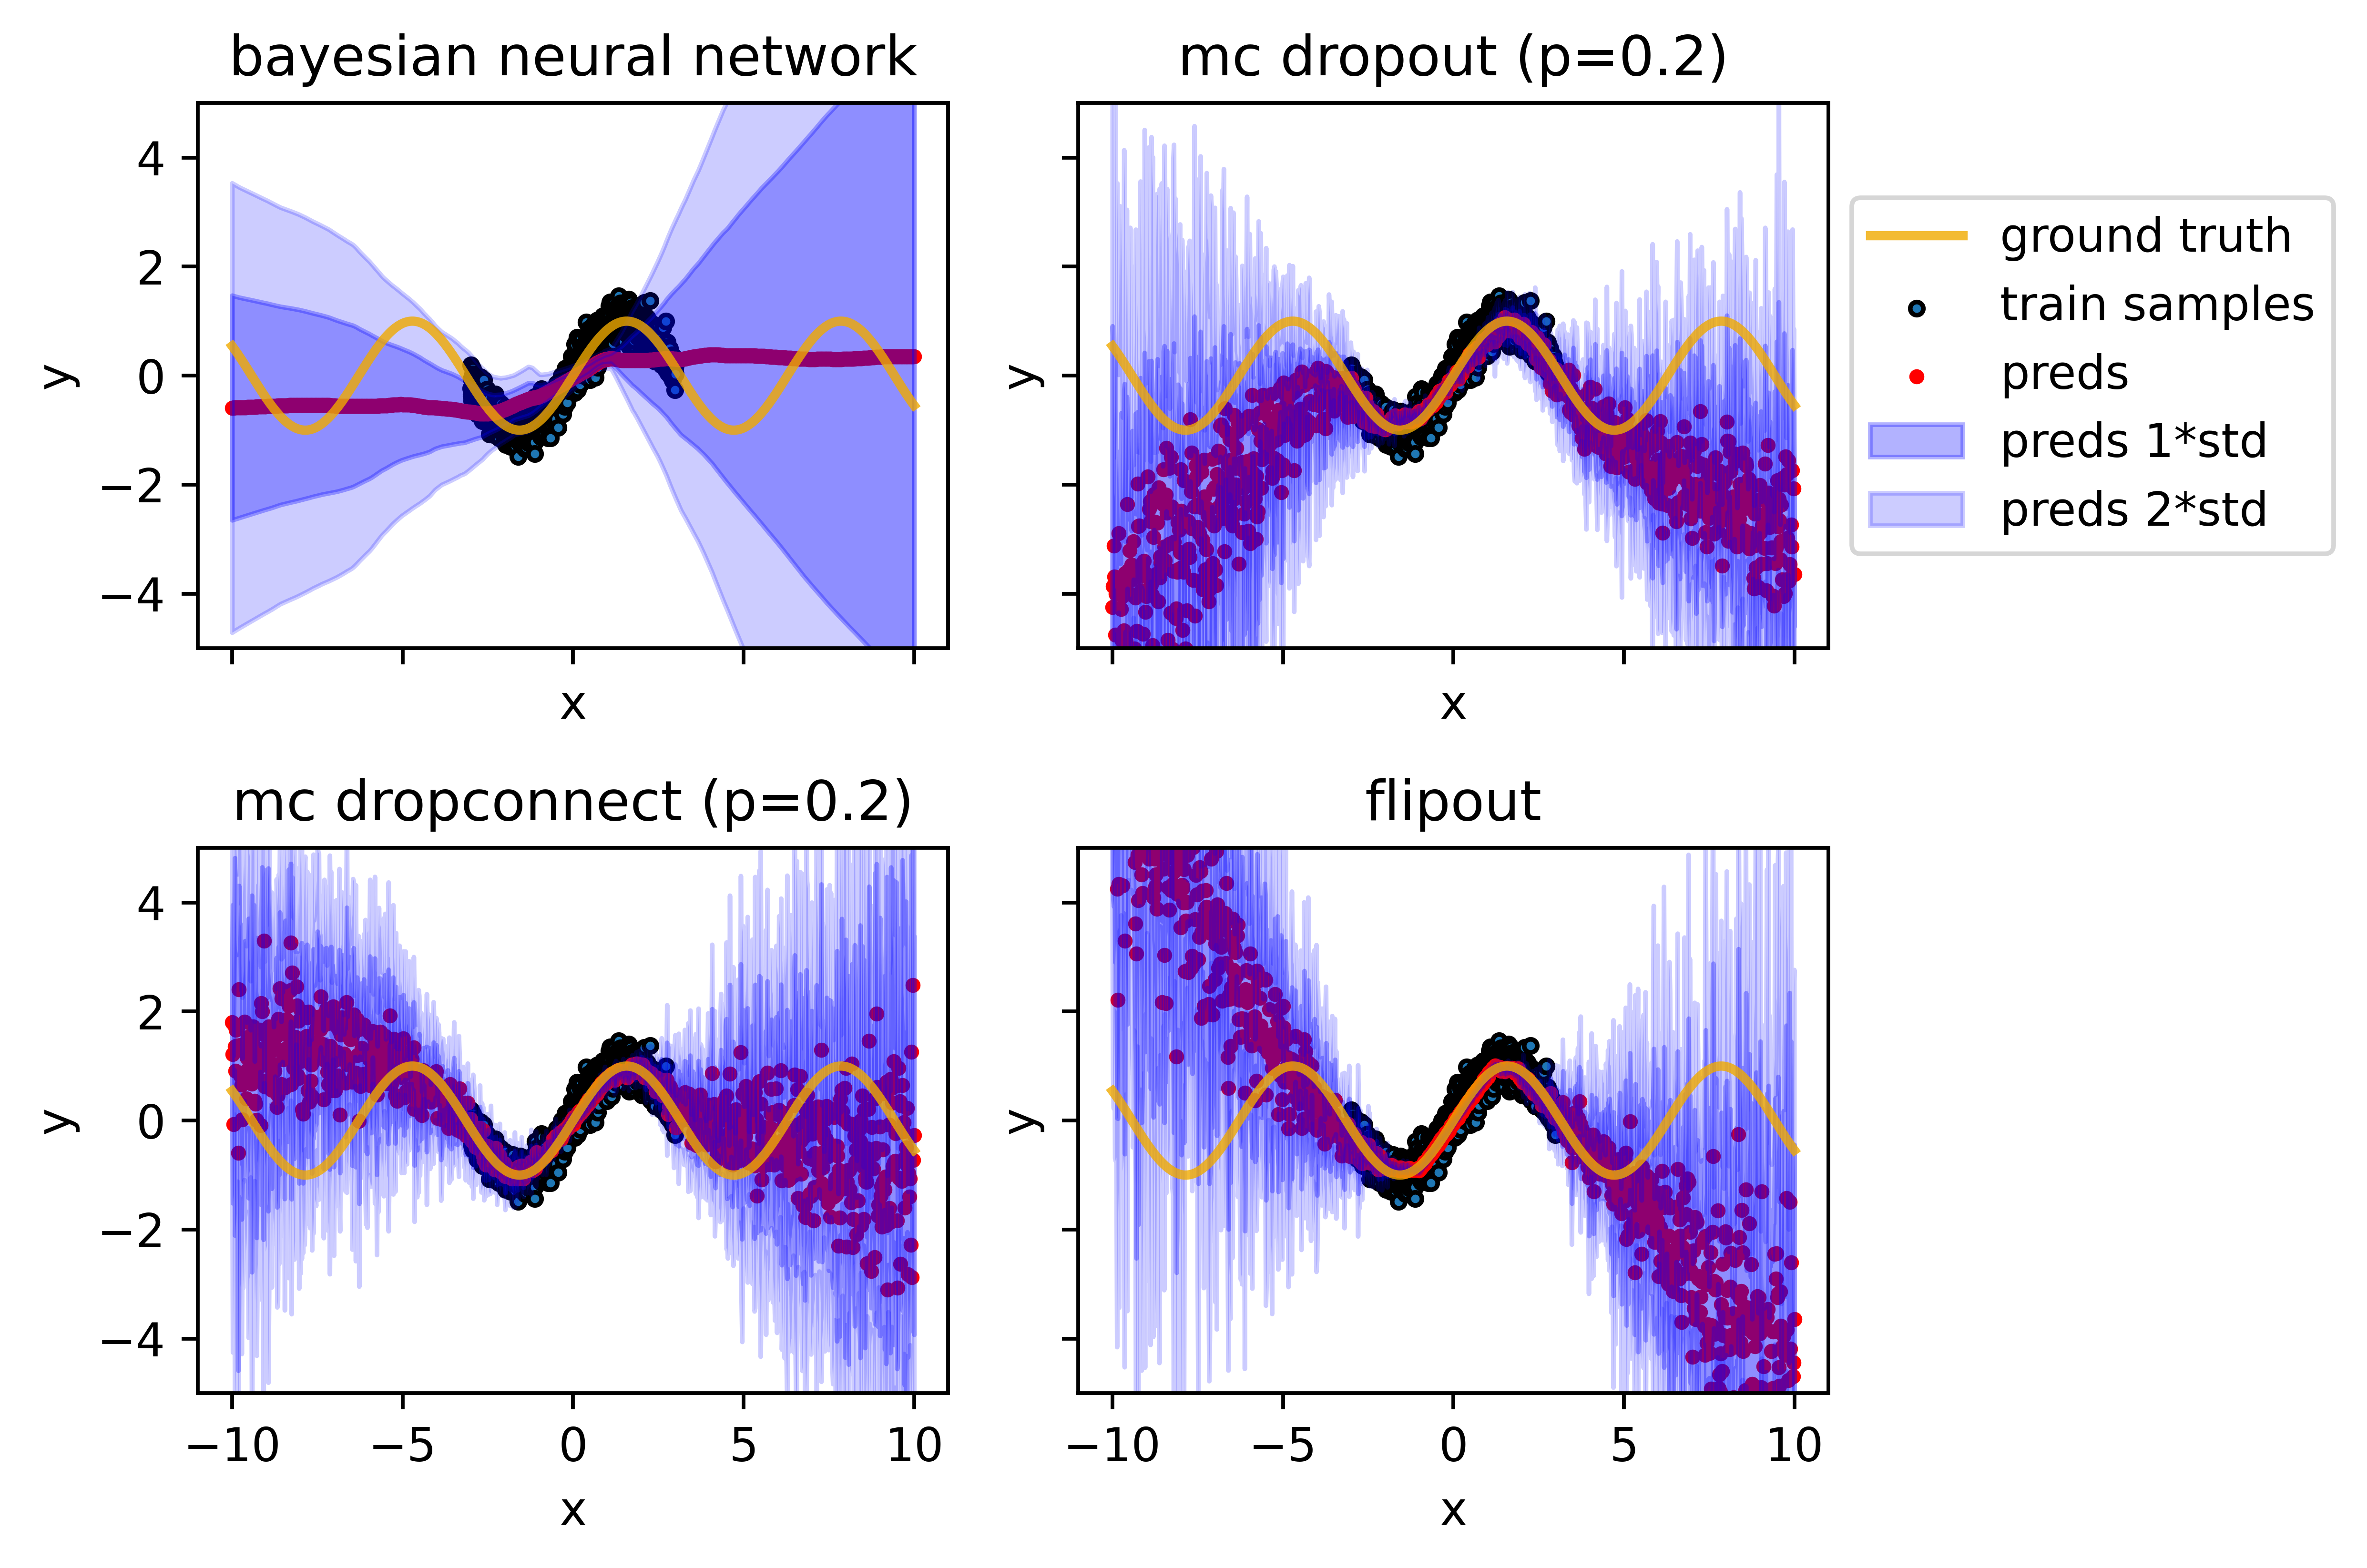

In [9]:
fig, ax = plt.subplots(2, 2, dpi=700, sharex=True, sharey=True)
ax[0, 0] = plot_regression_model_analysis(
    ground_truth=(x_ground_truth, y_ground_truth),
    train=(x_train, y_train),
    pred=(x_test, *y_pred["bnn"]),
    xlim=(-11, 11),
    ylim=(-5, 5),
    title="bayesian neural network",
    ax=ax[0, 0],
)
ax[0, 0].get_legend().remove()

ax[0, 1] = plot_regression_model_analysis(
    ground_truth=(x_ground_truth, y_ground_truth),
    train=(x_train, y_train),
    pred=(x_test, *y_pred["dropout"]),
    xlim=(-11, 11),
    ylim=(-5, 5),
    title="mc dropout (p={:.1f})".format(p),
    ax=ax[0, 1],
)

ax[1, 0] = plot_regression_model_analysis(
    ground_truth=(x_ground_truth, y_ground_truth),
    train=(x_train, y_train),
    pred=(x_test, *y_pred["dropconnect"]),
    xlim=(-11, 11),
    ylim=(-5, 5),
    title="mc dropconnect (p={:.1f})".format(p),
    ax=ax[1, 0],
)
ax[1, 0].get_legend().remove()

ax[1, 1] = plot_regression_model_analysis(
    ground_truth=(x_ground_truth, y_ground_truth),
    train=(x_train, y_train),
    pred=(x_test, *y_pred["flipout"]),
    xlim=(-11, 11),
    ylim=(-5, 5),
    title="flipout",
    ax=ax[1, 1],
)
ax[1, 1].get_legend().remove()

fig.tight_layout()
ax[0, 1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("../assets/all.png", bbox_inches="tight")